In [1]:
# import the libraries 
!pip install tensorflow tensorflow opencv-python matplotlib

In [2]:
import tensorflow as tf
import os

In [3]:
gpus=tf.config.experimental.list_physical_devices('CPU')
gpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
#Avoid OOm error by settig Gpu Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [5]:
#Remove the dodgy images 
import cv2
import imghdr

In [6]:
# Load the data 
data_dir = "data"

In [7]:
#check the data dictory
os.listdir(data_dir)

['damage pallets', 'good pallets']

In [8]:
#image exist in four format
image_exts = ['jpeg','jpg','bmp','png']


In [12]:
#now see the imagesformat
image_exts[1]

'jpg'

In [13]:
#Removing the UnWanted images 
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir,image_class,image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('image not in exist list {}' .format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

image not in exist list data\damage pallets\damaged-wooden-pallet-3d-rendering-260nw-558372889.jpg
image not in exist list data\damage pallets\ets-in-a-damaged-and-messy-condition-in-a-temporary-disposal-site-2231443585.jpg
image not in exist list data\damage pallets\ets-in-a-damaged-and-messy-condition-in-a-temporary-disposal-site-2231443591.jpg
image not in exist list data\damage pallets\vector.svg
image not in exist list data\damage pallets\vector10.svg
image not in exist list data\damage pallets\vector11.svg
image not in exist list data\damage pallets\vector12.svg
image not in exist list data\damage pallets\vector13.svg
image not in exist list data\damage pallets\vector14.svg
image not in exist list data\damage pallets\vector15.svg
image not in exist list data\damage pallets\vector2.svg
image not in exist list data\damage pallets\vector3.svg
image not in exist list data\damage pallets\vector4.svg
image not in exist list data\damage pallets\vector5.svg
image not in exist list data\d

In [14]:
#import libraries
import numpy as np
from matplotlib import pyplot as plt

In [17]:
#checking the data 
data = tf.keras.utils.image_dataset_from_directory('data')

Found 262 files belonging to 2 classes.


In [18]:
#numpy iterator to extact data from Generators
data_iterator = data.as_numpy_iterator()

In [19]:
batch = data_iterator.next()

In [20]:
#Images represented as numpy array
batch[0].shape

(32, 256, 256, 3)

In [21]:
#now see the batch 1
batch[1]

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1])

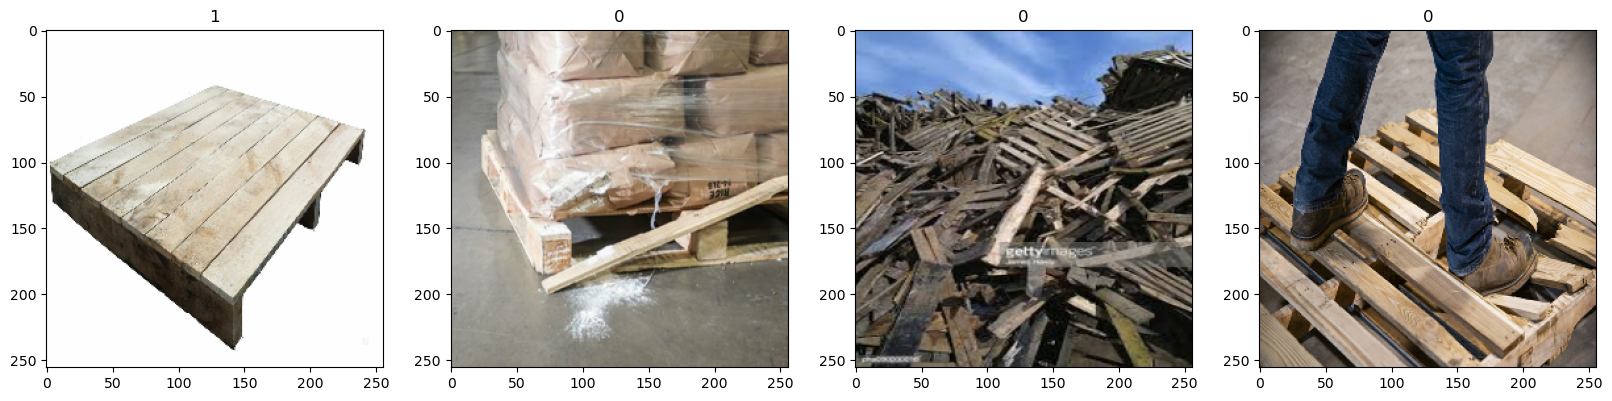

In [23]:
#Visualization
fig, ax =plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    #here class 0 is damage pallet
    #here class 1 is good pallet

In [24]:
#preprocess the data 
#scaled the data with 255
data = data.map(lambda x,y: (x/255, y))

In [25]:
scale_iterator = data.as_numpy_iterator()

In [26]:
batch = scale_iterator.next()

In [27]:
batch[0].max()

1.0

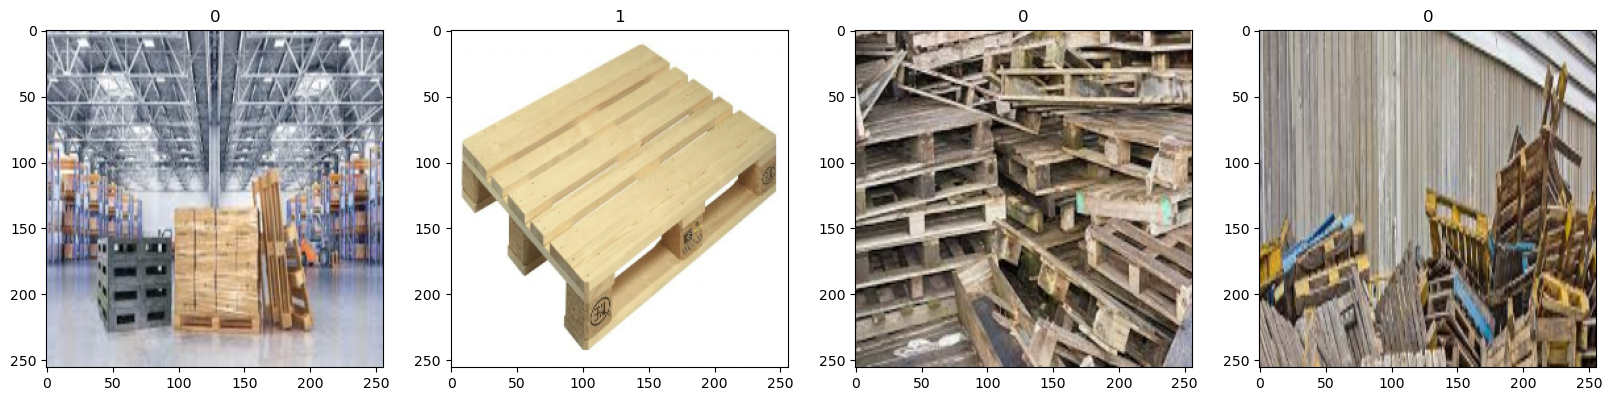

In [28]:
#visulization
fig, ax =plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [30]:
#split the data 
len(data) #lenght of the data is 9 batches

9

In [33]:
# test and train data with percentage
train_size = int(len(data)*.7)
test_size = int(len(data)*.2)+1
val_size = int(len(data)*.1)+1

In [34]:
#check the total size
test_size+train_size+val_size

9

In [35]:
#test and train split
train =data.take(train_size)
val =data.skip(train_size).take(val_size)
test =data.skip(train_size+val_size).take(test_size)

In [113]:
#build the deep learning model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras import layers, models


In [123]:
#Build the model
model = Sequential()

In [124]:
model.add(Conv2D(16,(3,3),1, activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())
#model.add(layers.Dropout(0.25))

model.add(Conv2D(32,(3,3),1, activation='relu'))
model.add(MaxPooling2D())
#model.add(layers.Dropout(0.25))

model.add(Conv2D(16,(3,3),1, activation='relu'))
model.add(MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [125]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [126]:
#see the model summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 30, 16)      

In [127]:
#Train data 
logdir = 'logs'

In [128]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [129]:
hist = model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
6/6 [==============================] - 7s 797ms/step - loss: 0.7757 - accuracy: 0.6146 - val_loss: 0.6676 - val_accuracy: 0.6875
Epoch 2/20
6/6 [==============================] - 5s 757ms/step - loss: 0.6959 - accuracy: 0.6562 - val_loss: 0.5927 - val_accuracy: 0.7500
Epoch 3/20
6/6 [==============================] - 5s 779ms/step - loss: 0.6200 - accuracy: 0.6979 - val_loss: 0.5881 - val_accuracy: 0.6562
Epoch 4/20
6/6 [==============================] - 5s 764ms/step - loss: 0.5479 - accuracy: 0.7031 - val_loss: 0.4815 - val_accuracy: 0.6562
Epoch 5/20
6/6 [==============================] - 5s 764ms/step - loss: 0.5167 - accuracy: 0.7083 - val_loss: 0.4348 - val_accuracy: 0.7500
Epoch 6/20
6/6 [==============================] - 9s 1s/step - loss: 0.4963 - accuracy: 0.7604 - val_loss: 0.5782 - val_accuracy: 0.7188
Epoch 7/20
6/6 [==============================] - 8s 1s/step - loss: 0.4580 - accuracy: 0.7917 - val_loss: 0.3429 - val_accuracy: 0.8125
Epoch 8/20
6/6 [==========

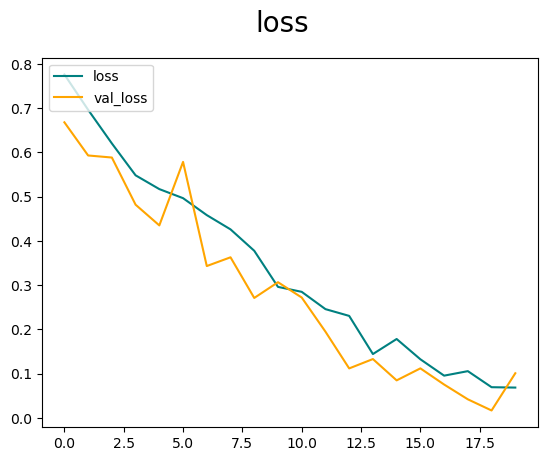

In [130]:
# loss  performance plotting 
fig =plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

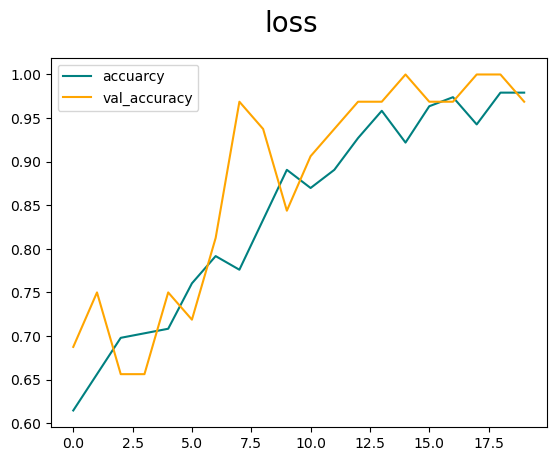

In [131]:
#accuracy  performance plotting
fig =plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuarcy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [132]:
#evalute performance
from tensorflow.keras.metrics import Precision, Recall,BinaryAccuracy

In [134]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [135]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat= model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 [==============================] - 0s 177ms/step


In [136]:
print(f'Precision:{pre.result().numpy()},Recall:{re.result().numpy()},Accuracy:{acc.result().numpy()}')

Precision:1.0,Recall:0.9230769276618958,Accuracy:0.9736841917037964


In [137]:
#test
import cv2

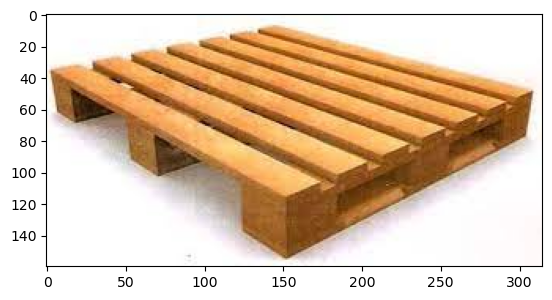

In [155]:
#passing the test image
img = cv2.imread('test.goodpallet.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

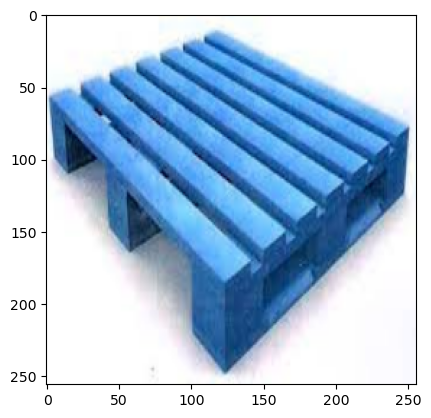

In [156]:
# resize the test image
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [157]:
#resize the shape
resize.shape

TensorShape([256, 256, 3])

In [158]:
#convert np array
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [159]:
yhat =model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 37ms/step


In [160]:
yhat

array([[0.99913645]], dtype=float32)

In [161]:
if yhat > 0.5:
    print(f'Predicted class is goodpallet')
else:
    print(f'Predicted class is damagepallet')

Predicted class is goodpallet


In [162]:
#save the model
from tensorflow.keras.models import load_model

In [163]:
model.save(os.path.join('model','imageclassifier.h5'))